In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Parameter(torch.Tensor(input_dim, hidden_dim))
        nn.init.xavier_uniform_(self.encoder)
        self.relu = nn.ReLU()
        # Initialize bias to be of size (1, input_dim)
        self.bias = nn.Parameter(torch.zeros(1, input_dim))

    def forward(self, x):
        h = self.relu(torch.matmul(x, self.encoder))  # x @ encoder
        transposed_weight = self.encoder.t()  # transposed_weight = encoder.T
        matmul_result = torch.matmul(h, transposed_weight)  # h @ transposed_weight
        # Add bias, broadcasting across the batch dimension
        result_with_bias = matmul_result + self.bias
        y_hat = self.relu(result_with_bias)
        return y_hat

def generate_data(n_features, n_samples, sparsity):
    x = torch.rand(n_samples, n_features)
    mask = torch.rand_like(x) > sparsity
    x = torch.mul(x, mask.float())
    return x # shape (batch_size, n_features)

def loss_fn(y_pred, y_true, importance):
    weights = torch.Tensor(importance).to(y_true.device)
    mse = (y_pred - y_true)**2 # shape (batch_size, n_features)
    # now for loss, we want the weights to be applied to each column
    loss = torch.einsum('bi,i->b', mse, weights) # shape (batch_size,)
    return torch.mean(loss)


In [71]:
def train_model(num_features, model_dimensions, batch_size, sparsity, num_epochs):
    # Define the model
    model = Autoencoder(num_features, model_dimensions)

    # use loss_fn as the loss function
    # importance = [0.7**i for i in range(num_features)]
    importance = (100 ** -torch.linspace(0, 1, num_features)).numpy()
    importance = np.array([1 for i in range(num_features)])
    criterion = lambda y_pred, y_true: loss_fn(y_pred, y_true, importance)

    # Define the optimizer
    optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-2)

    # Define the scheduler for learning rate decay
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)

    # Training loop
    with tqdm(total=num_epochs, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]') as pbar:
        for epoch in range(num_epochs):
            
            x = generate_data(num_features, batch_size, sparsity)
            # ===================forward=====================
            output = model(x)
            loss = criterion(output, x)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # ===================log========================
            pbar.set_postfix({'loss': loss.item(), 'lr': scheduler.get_last_lr()[0]})
            pbar.update()

            # Step the learning rate scheduler
            scheduler.step()

    return model


In [55]:
S_vals = 1-(20 ** -torch.linspace(0, 1, 6))
num_epochs = 3000
num_features = 20
model_dimensions = 5
batch_size = 1000
# train models with different sparsity
models = []
for S in S_vals:
    model = train_model(num_features, model_dimensions, batch_size, S, num_epochs)
    models.append(model)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [47]:
model.encoder[:,1]

tensor([ 0.0615,  0.5464, -0.4906,  0.4945,  0.9832,  0.7148, -0.6009, -0.2395,
        -0.3647, -0.1300, -0.6257,  0.0171,  0.0241,  0.0281,  0.0309,  0.0340,
         0.0358,  0.0396,  0.0426,  0.0452], grad_fn=<SelectBackward0>)

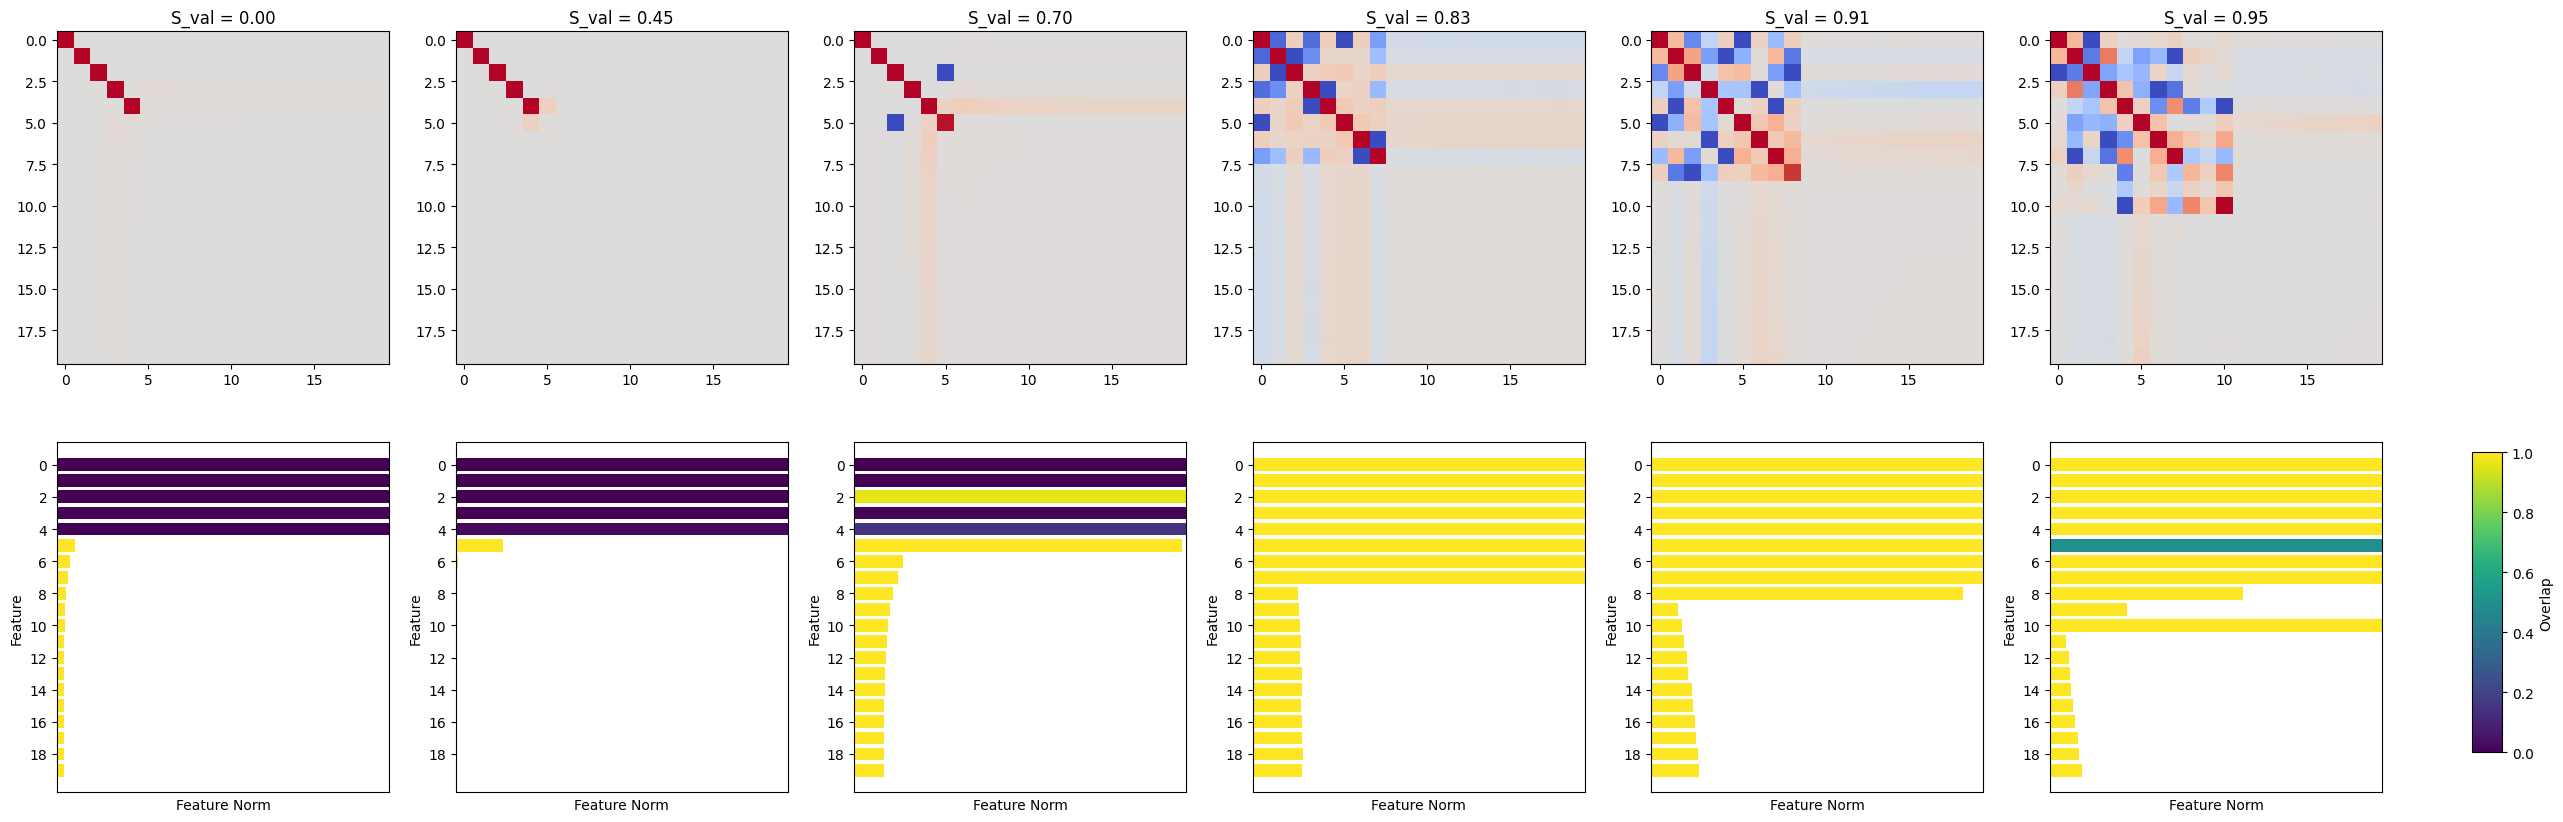

In [48]:


import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

num_models = len(models)
fig, axes = plt.subplots(2, num_models, figsize=(num_models*5, 10))

for idx, model in enumerate(models):
    W = model.encoder.detach().cpu().numpy().T  # Transposed for correct shape
    W_norm = W / (1e-5 + np.linalg.norm(W, axis=0, keepdims=True))  # Normalized weights

    # Interference calculation (dot product of all pairs of normalized weight vectors)
    interference = np.dot(W_norm.T, W)

    # Remove self-interference by setting diagonal to 0
    np.fill_diagonal(interference, 0)

    # Polysemanticity (L2 norm of interference for each feature)
    polysemanticity = np.linalg.norm(interference, axis=1)

    # Overlaps (sum of squared cosine similarities, excluding self-comparison)
    overlaps = np.sum(interference**2 - np.diag(np.diag(interference**2)), axis=1)

    # Norms (L2 norm of the original weight vectors)
    norms = np.linalg.norm(W, axis=0)

    
    # Visualize W*W^T and biases in one figure
    im = axes[0, idx].imshow(np.matmul(W.T, W), cmap='coolwarm', vmin=-1, vmax=1)
    axes[0, idx].set_title(f'S_val = {S_vals[idx]:.2f}')  # Added title for each column with S_val
    axes[1, idx].barh(np.arange(len(norms)), norms, color=cm.viridis(colors.Normalize(vmin=0, vmax=1)(overlaps)))
    axes[1, idx].invert_yaxis()
    axes[1, idx].set_xlim([0, 1])
    axes[1, idx].set_xticks([])
    axes[1, idx].set_yticks(np.arange(0, 20, step=2))
    axes[1, idx].set_xlabel('Feature Norm')  # Added x label for bottom plot
    axes[1, idx].set_ylabel('Feature')  # Added y label for bottom plot

# Add a colorbar for the overlap on the bar graphs
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.3])
norm = colors.Normalize(vmin=0, vmax=1)
sm = cm.ScalarMappable(cmap=cm.viridis, norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, orientation='vertical', label='Overlap')

plt.show()



In [57]:
sparsity = 0.
num_epochs = 3000
num_features = 20
model_dimensions = np.arange(1,21)
print(model_dimensions)
batch_size = 1000
# train models with different sparsity
models = []
for md in model_dimensions:
    model = train_model(num_features, md, batch_size, sparsity, num_epochs)
    models.append(model)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [65]:
sparsity = 0.45
num_epochs = 3000
num_features = 20
model_dimensions = np.arange(1,21)
print(model_dimensions)
batch_size = 1000
# train models with different sparsity
odels = []
for md in model_dimensions:
    model = train_model(num_features, md, batch_size, sparsity, num_epochs)
    odels.append(model)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [72]:
sparsity = 0.
num_epochs = 3000
num_features = 20
model_dimensions = np.arange(1,21)
print(model_dimensions)
batch_size = 1000
# train models with different sparsity
uniform_imp = []
for md in model_dimensions:
    model = train_model(num_features, md, batch_size, sparsity, num_epochs)
    uniform_imp.append(model)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [74]:
sparsity = 0.45
num_epochs = 3000
num_features = 20
model_dimensions = np.arange(1,21)
print(model_dimensions)
batch_size = 1000
# train models with different sparsity
uniform_imp_sparse = []
for md in model_dimensions:
    model = train_model(num_features, md, batch_size, sparsity, num_epochs)
    uniform_imp_sparse.append(model)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

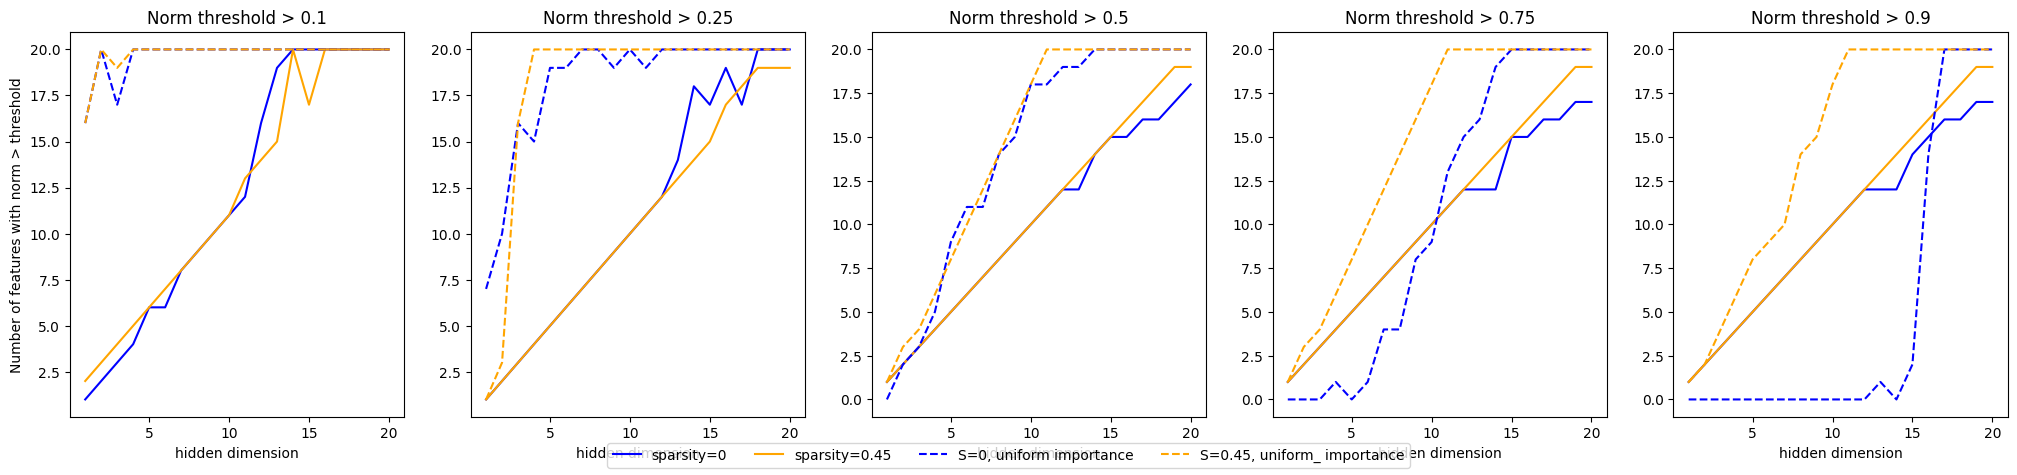

In [86]:


def calculate_norms(models,thresh):
    nn_models = []
    for idx, model in enumerate(models):
        W = model.encoder.detach().cpu().numpy().T  # Transposed for correct shape
        W_norm = W / (1e-5 + np.linalg.norm(W, axis=0, keepdims=True))  # Normalized weights

        # Interference calculation (dot product of all pairs of normalized weight vectors)
        interference = np.dot(W_norm.T, W)

        # Remove self-interference by setting diagonal to 0
        np.fill_diagonal(interference, 0)

        # Polysemanticity (L2 norm of interference for each feature)
        polysemanticity = np.linalg.norm(interference, axis=1)

        # Overlaps (sum of squared cosine similarities, excluding self-comparison)
        overlaps = np.sum(interference**2 - np.diag(np.diag(interference**2)), axis=1)

        # Norms (L2 norm of the original weight vectors)
        norms = np.linalg.norm(W, axis=0)

        # count how many norms are > 0.1
        n = np.sum(norms > thresh)
        nn_models.append(n)
    return nn_models

thresh = [0.1,0.25,0.5,0.75,0.9]

# make a plot for each threshold, 1 figure n cols
fig, axes = plt.subplots(1, len(thresh), figsize=(len(thresh)*5, 5))

for idx, t in enumerate(thresh):
    nn_models = calculate_norms(models,t)
    nn_odels = calculate_norms(odels,t)
    nn_uniform_imp = calculate_norms(uniform_imp,t)
    nn_uniform_imp_sparse = calculate_norms(uniform_imp_sparse,t)

    # plot
    axes[idx].plot(model_dimensions, nn_models, label='sparsity=0', color='blue', linestyle='-')
    axes[idx].plot(model_dimensions, nn_odels, label='sparsity=0.45', color='orange', linestyle='-')
    axes[idx].plot(model_dimensions, nn_uniform_imp, label='S=0, uniform importance', color='blue', linestyle='--')
    axes[idx].plot(model_dimensions, nn_uniform_imp_sparse, label='S=0.45, uniform_ importance', color='orange', linestyle='--')
    axes[idx].set_xlabel('hidden dimension')
    axes[idx].set_title(f'Norm threshold > {t}')
    if idx == 0:
        axes[idx].set_ylabel('Number of features with norm > threshold')

# Add legend at the bottom of the figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4)



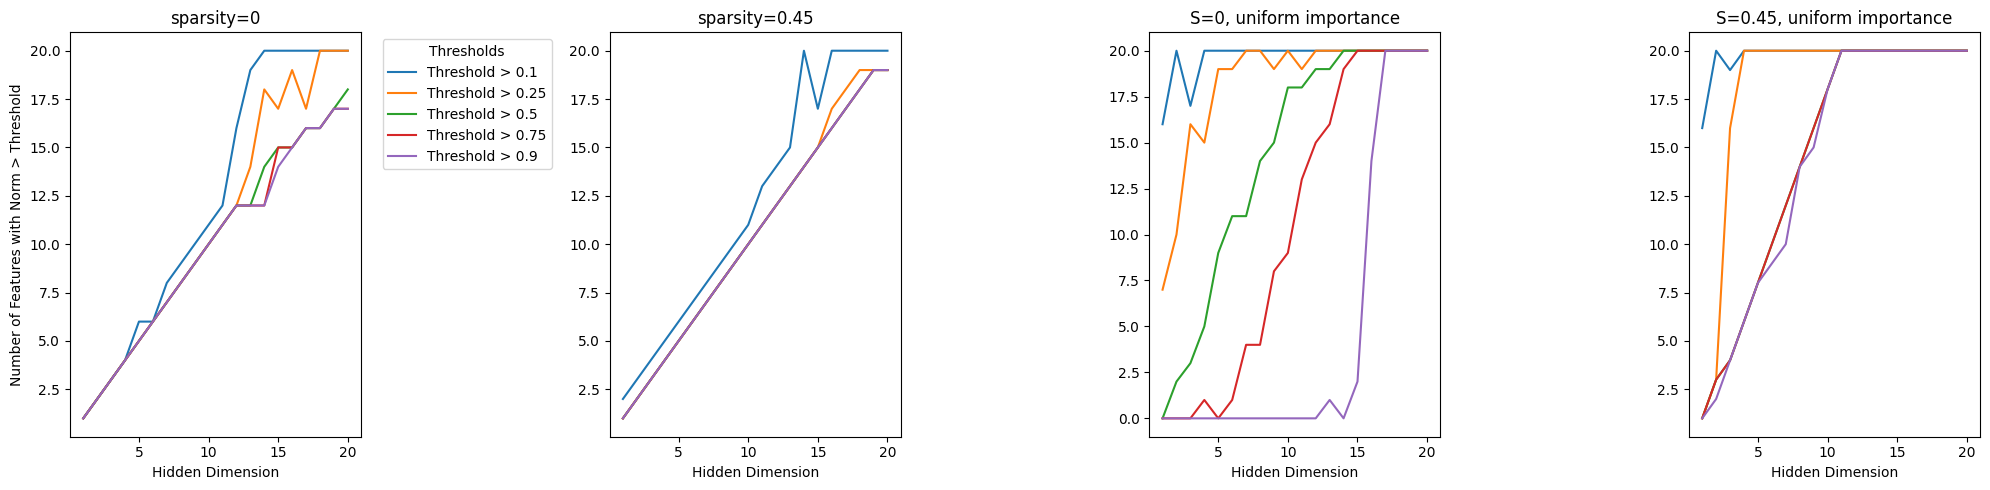

In [87]:

import matplotlib.pyplot as plt
import numpy as np

# Assuming calculate_norms function and model lists (models, odels, uniform_imp, uniform_imp_sparse) are defined

thresh = [0.1, 0.25, 0.5, 0.75, 0.9]

# Creating the figure with 4 subplots (one for each model type)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# List of model types for iteration
model_types = [models, odels, uniform_imp, uniform_imp_sparse]
model_labels = ['sparsity=0', 'sparsity=0.45', 'S=0, uniform importance', 'S=0.45, uniform importance']

# Iterate over each model type and plot each threshold on the respective subplot
for idx, model_type in enumerate(model_types):
    for t in thresh:
        nn_models = calculate_norms(model_type, t)
        axes[idx].plot(model_dimensions, nn_models, label=f'Threshold > {t}')

    axes[idx].set_title(model_labels[idx])
    axes[idx].set_xlabel('Hidden Dimension')
    if idx == 0:
        axes[idx].set_ylabel('Number of Features with Norm > Threshold')

# Add legend
axes[0].legend(title="Thresholds", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()



C:\Users\adamimos\AppData\Local\Temp\ipykernel_33260\2144597876.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


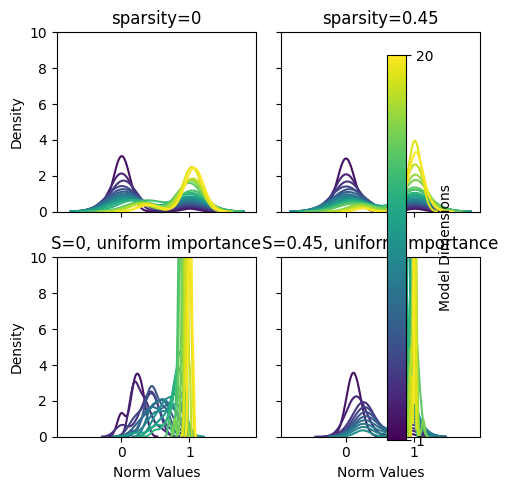

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def calculate_norms(models):
    all_norms = []
    for model in models:
        W = model.encoder.detach().cpu().numpy().T
        norms = np.linalg.norm(W, axis=0)
        all_norms.append(norms)  # Changed from extend to append to keep norms separate
    return all_norms

model_types = [models, odels, uniform_imp, uniform_imp_sparse]
model_labels = ['sparsity=0', 'sparsity=0.45', 'S=0, uniform importance', 'S=0.45, uniform importance']

# Create a figure with a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(5, 5), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for idx, model_type in enumerate(model_types):
    for dim, norms in zip(model_dimensions, calculate_norms(model_type)):  # Added zip to iterate over dimensions and norms together

        # Plotting KDE with a color gradient based on model dimension
        sns.kdeplot(norms, ax=axes[idx], label=f'Dim {dim}', 
                    color=plt.cm.viridis(dim / max(model_dimensions)))

    axes[idx].set_title(model_labels[idx])
    axes[idx].set_xlabel('Norm Values')
    
    # set y limits to be 0 to 1
    axes[idx].set_ylim([0, 10])

# Add a colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=axes, orientation='vertical', label='Model Dimensions', pad=0.01)
cbar.set_ticks([0, 1])
cbar.set_ticklabels([min(model_dimensions), max(model_dimensions)])

plt.tight_layout()
plt.show()


C:\Users\adamimos\AppData\Local\Temp\ipykernel_33260\3446047040.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


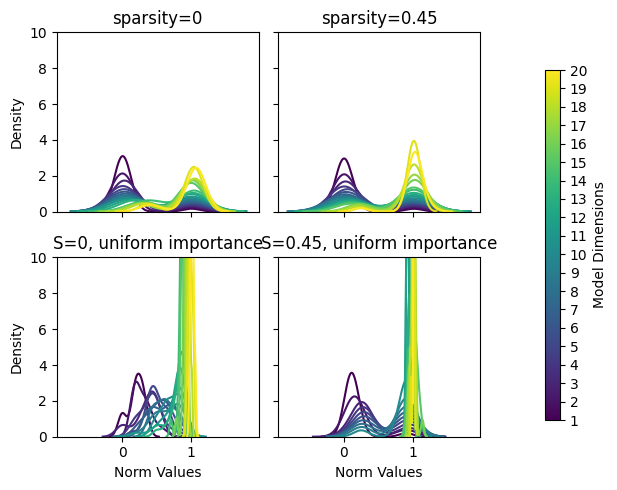

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ... [your existing code for calculate_norms and model setup] ...

fig, axes = plt.subplots(2, 2, figsize=(5, 5), sharex=True, sharey=True)  # Increased figsize for better spacing
axes = axes.flatten()

for idx, model_type in enumerate(model_types):
    for dim, norms in zip(model_dimensions, calculate_norms(model_type)):
        sns.kdeplot(norms, ax=axes[idx], label=f'Dim {dim}', 
                    color=plt.cm.viridis((dim - min(model_dimensions)) / (max(model_dimensions) - min(model_dimensions))))

    axes[idx].set_title(model_labels[idx])
    axes[idx].set_xlabel('Norm Values')
    axes[idx].set_ylim([0, 10])

# Adjust the layout before adding the colorbar
plt.subplots_adjust(right=0.8)  # Adjust the right margin to create space for the colorbar

# Adding the colorbar
cbar_ax = fig.add_axes([1.1, 0.15, 0.03, 0.7])  # Position the colorbar [left, bottom, width, height]
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), cax=cbar_ax)
cbar.set_label('Model Dimensions')
cbar.set_ticks(np.linspace(0, 1, len(model_dimensions)))
cbar.set_ticklabels(model_dimensions)

plt.tight_layout()
plt.show()


# Add Dropout

Quickly lets think about what dropout should do. If we add dropout to the hidden layers, then lets say we got a situation where feature 1 and 2 are active. Now during one run the network will effectively only have a random sampling of <m dimensions, and on another it will be some other random sampling. I hypothesize this forces the network to represent fewer features overall, and with more overlap. Let's take an S_val = 0.07 and do a sweep of different dropout rates and see what happens.

In [50]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.5):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Parameter(torch.Tensor(input_dim, hidden_dim))
        nn.init.xavier_uniform_(self.encoder)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer
        self.bias = nn.Parameter(torch.zeros(1, input_dim))

    def forward(self, x):
        h = self.relu(torch.matmul(x, self.encoder))
        h = self.dropout(h)  # Apply dropout to the hidden layer
        transposed_weight = self.encoder.t()
        matmul_result = torch.matmul(h, transposed_weight)
        result_with_bias = matmul_result + self.bias
        y_hat = self.relu(result_with_bias)
        return y_hat


def train_model(num_features, model_dimensions, batch_size, sparsity, num_epochs, dropout_rate=0.5):
    # Define the model with dropout
    model = Autoencoder(num_features, model_dimensions, dropout_rate)

    # use loss_fn as the loss function
    # importance = [0.7**i for i in range(num_features)]
    importance = (100 ** -torch.linspace(0, 1, num_features)).numpy()
    criterion = lambda y_pred, y_true: loss_fn(y_pred, y_true, importance)

    # Define the optimizer
    optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-2)

    # Define the scheduler for learning rate decay
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.1)

    # Training loop
    with tqdm(total=num_epochs, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]') as pbar:
        for epoch in range(num_epochs):
            
            x = generate_data(num_features, batch_size, sparsity)
            # ===================forward=====================
            output = model(x)
            loss = criterion(output, x)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # ===================log========================
            pbar.set_postfix({'loss': loss.item(), 'lr': scheduler.get_last_lr()[0]})
            pbar.update()

            # Step the learning rate scheduler
            scheduler.step()

    return model

dropout_rates = np.linspace(0, 0.9, 6)
num_epochs = 3000
num_features = 20
model_dimensions = 5
batch_size = 1024*4
sparsity = 0.45 #0.83
# train models with different sparsity
models = []
for d in dropout_rates:
    model = train_model(num_features, model_dimensions, batch_size, sparsity, num_epochs, dropout_rate=d)
    models.append(model)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

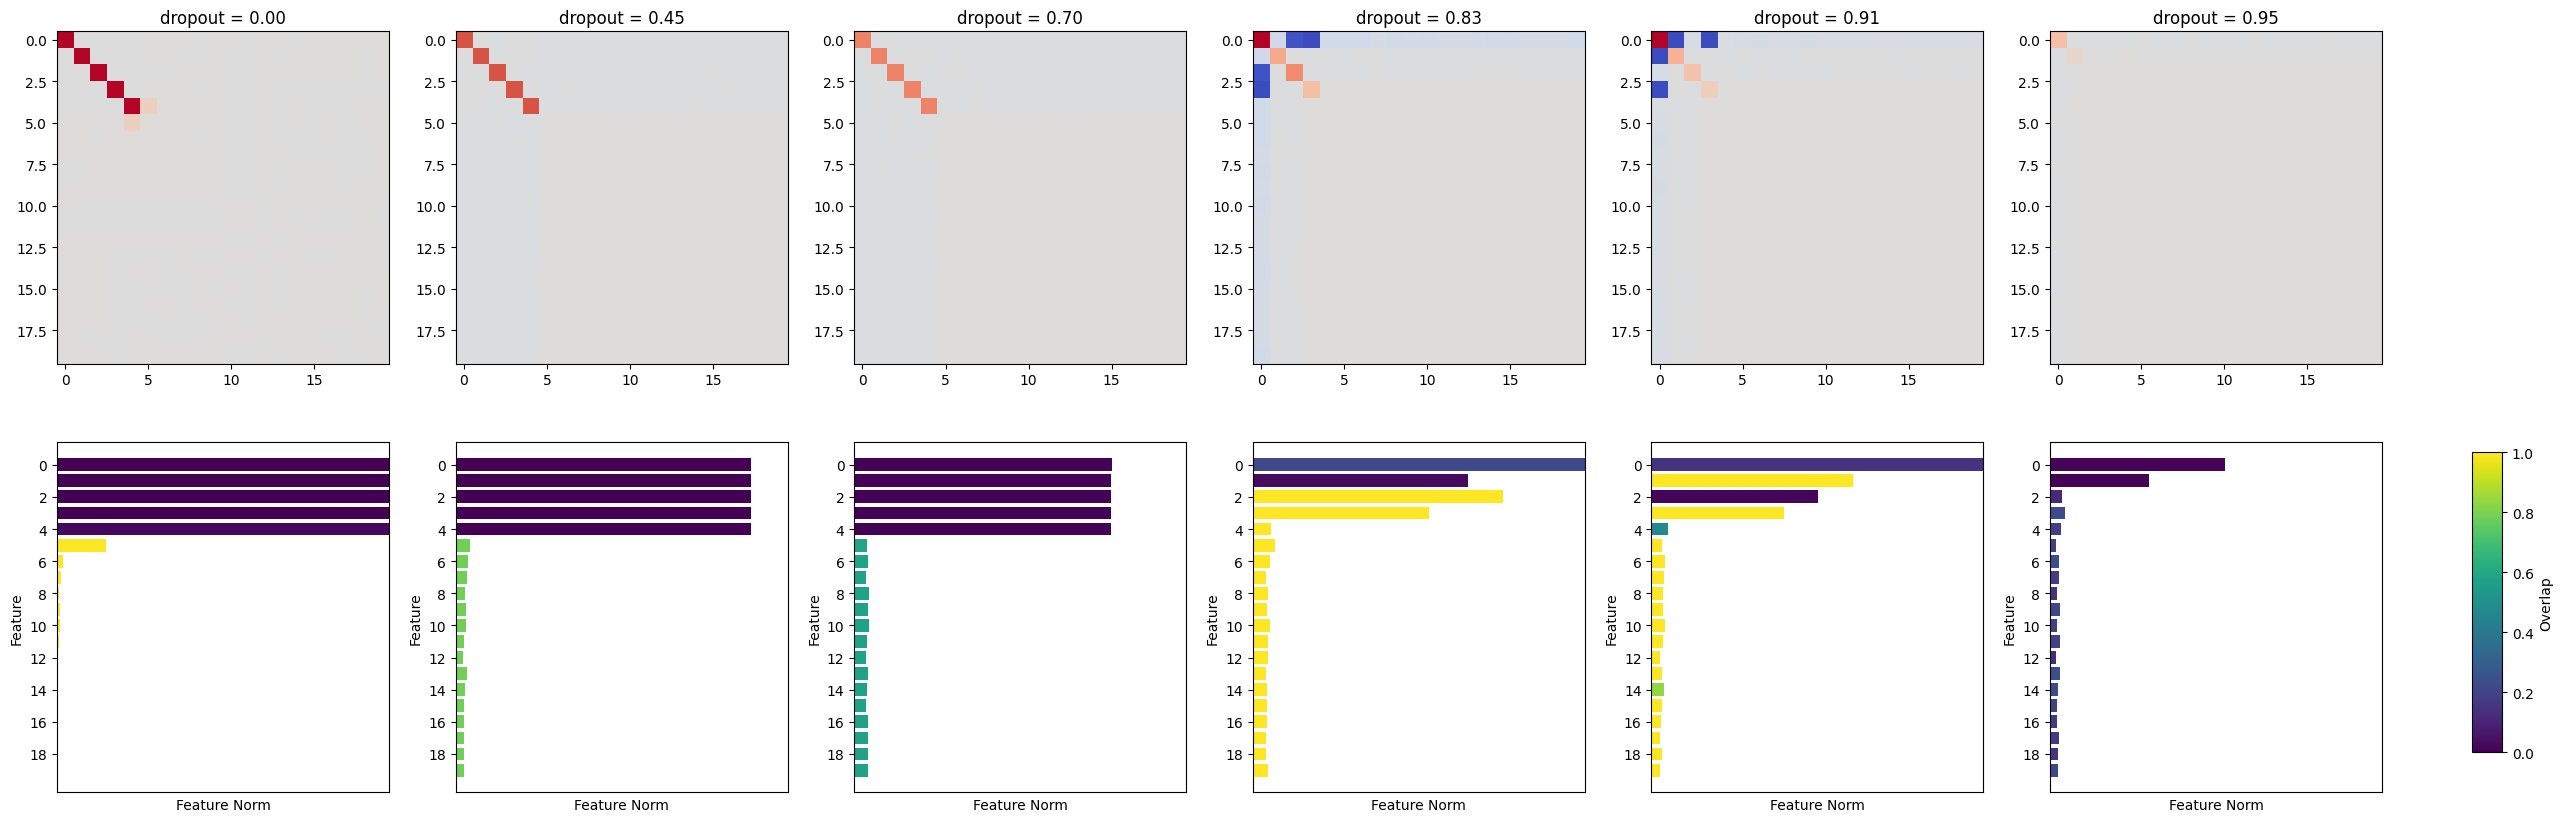

In [51]:


import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

num_models = len(models)
fig, axes = plt.subplots(2, num_models, figsize=(num_models*5, 10))

for idx, model in enumerate(models):
    W = model.encoder.detach().cpu().numpy().T  # Transposed for correct shape
    W_norm = W / (1e-5 + np.linalg.norm(W, axis=0, keepdims=True))  # Normalized weights

    # Interference calculation (dot product of all pairs of normalized weight vectors)
    interference = np.dot(W_norm.T, W)

    # Remove self-interference by setting diagonal to 0
    np.fill_diagonal(interference, 0)

    # Polysemanticity (L2 norm of interference for each feature)
    polysemanticity = np.linalg.norm(interference, axis=1)

    # Overlaps (sum of squared cosine similarities, excluding self-comparison)
    overlaps = np.sum(interference**2 - np.diag(np.diag(interference**2)), axis=1)

    # Norms (L2 norm of the original weight vectors)
    norms = np.linalg.norm(W, axis=0)

    
    # Visualize W*W^T and biases in one figure
    im = axes[0, idx].imshow(np.matmul(W.T, W), cmap='coolwarm', vmin=-1, vmax=1)
    axes[0, idx].set_title(f'dropout = {S_vals[idx]:.2f}')  # Added title for each column with S_val
    axes[1, idx].barh(np.arange(len(norms)), norms, color=cm.viridis(colors.Normalize(vmin=0, vmax=1)(overlaps)))
    axes[1, idx].invert_yaxis()
    axes[1, idx].set_xlim([0, 1])
    axes[1, idx].set_xticks([])
    axes[1, idx].set_yticks(np.arange(0, 20, step=2))
    axes[1, idx].set_xlabel('Feature Norm')  # Added x label for bottom plot
    axes[1, idx].set_ylabel('Feature')  # Added y label for bottom plot

# Add a colorbar for the overlap on the bar graphs
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.3])
norm = colors.Normalize(vmin=0, vmax=1)
sm = cm.ScalarMappable(cmap=cm.viridis, norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, orientation='vertical', label='Overlap')

plt.show()



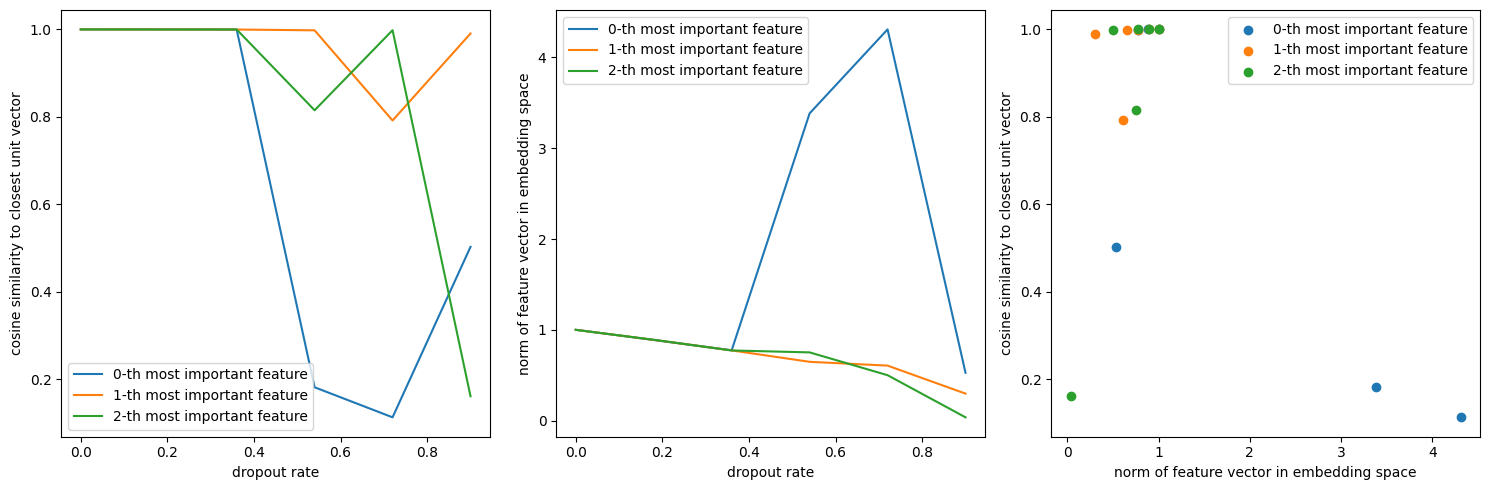

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

def plot_embedding(models, dropout_rates, emb_index, label = None):
    first_embedding = []
    for idx, model in enumerate(models):
        W = model.encoder.detach().cpu().numpy().T  # Transposed for correct shape
        W_norm = W / (1e-5 + np.linalg.norm(W, axis=0, keepdims=True))  # Normalized weights
        emb_vec = W_norm[:,emb_index]
        first_embedding.append(emb_vec.max())
    axs[0].plot(dropout_rates, first_embedding, label=label)

def plot_norm(models, dropout_rates, emb_index, label = None):
    norms = []
    for idx, model, in enumerate(models):
        W = model.encoder.detach().cpu().numpy().T  # Transposed for correct shape
        W_norm = np.linalg.norm(W, axis=0, keepdims=False)
        norms.append(W_norm[emb_index])
    axs[1].plot(dropout_rates, norms, label=label)

def plot_norm_vs_cosine(models, dropout_rates, emb_index, label = None):
    norms = []
    cosines = []
    for idx, model, in enumerate(models):
        W = model.encoder.detach().cpu().numpy().T  # Transposed for correct shape
        W_norm = np.linalg.norm(W, axis=0, keepdims=False)
        emb_vec = W[:,emb_index]
        norms.append(W_norm[emb_index])

        W_norm = W / (1e-5 + np.linalg.norm(W, axis=0, keepdims=True))  # Normalized weights
        emb_vec = W_norm[:,emb_index]
        cosines.append(emb_vec.max())
    axs[2].scatter(norms, cosines, label=label)

for i in range(3):
    plot_embedding(models, dropout_rates, i, label=f'{i}-th most important feature')
    plot_norm(models, dropout_rates, i, label=f'{i}-th most important feature')
    plot_norm_vs_cosine(models, dropout_rates, i, label=f'{i}-th most important feature')

axs[0].legend()
axs[0].set_xlabel('dropout rate')
axs[0].set_ylabel('cosine similarity to closest unit vector')

axs[1].legend()
axs[1].set_xlabel('dropout rate')
axs[1].set_ylabel('norm of feature vector in embedding space')

axs[2].legend()
axs[2].set_xlabel('norm of feature vector in embedding space')
axs[2].set_ylabel('cosine similarity to closest unit vector')

plt.tight_layout()
plt.show()

# Recreate the abs val results


In [116]:
class Autoencoder_compute(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder_compute, self).__init__()
        self.encoder = nn.Parameter(torch.Tensor(input_dim, hidden_dim))
        self.decoder = nn.Parameter(torch.Tensor(hidden_dim, input_dim))
        nn.init.xavier_uniform_(self.encoder)
        nn.init.xavier_uniform_(self.decoder)
        self.relu = nn.ReLU()
        # Initialize bias to be of size (1, input_dim)
        self.bias = nn.Parameter(torch.zeros(1, input_dim))

    def forward(self, x):
        h = self.relu(torch.matmul(x, self.encoder))  # x @ encoder
        matmul_result = torch.matmul(h, self.decoder)  
        # Add bias, broadcasting across the batch dimension
        result_with_bias = matmul_result + self.bias
        y_hat = self.relu(result_with_bias)
        return y_hat

def train_model_abs(num_features, model_dimensions, batch_size, sparsity, num_epochs, lr=1e-2, weight_decay=0.0, patience=500):
    # Define the model
    model = Autoencoder_compute(num_features, model_dimensions)

    # use loss_fn as the loss function
    importance = [0.8**i for i in range(num_features)]
    #importance = (100 ** -torch.linspace(0, 1, num_features)).numpy()
    criterion = lambda y_pred, y_true: loss_fn(y_pred, y_true, importance)

    # Define the optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Define the scheduler for learning rate decay
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
    # reduce lr on plataue
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, verbose=True)

    # Training loop
    with tqdm(total=num_epochs, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]') as pbar:
        for epoch in range(num_epochs):
            
            x = generate_data_abs(num_features, batch_size, sparsity)
            # ===================forward=====================
            output = model(x)
            loss = criterion(output, torch.abs(x))
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # ===================log========================
            pbar.set_postfix({'loss': loss.item(), 'lr': optimizer.param_groups[0]['lr']})
            pbar.update()

            # Step the learning rate scheduler
            scheduler.step(loss)

    return model

def generate_data_abs(n_features, n_samples, sparsity):
    x = 2 * torch.rand(n_samples, n_features) - 1
    mask = torch.rand_like(x) > sparsity
    x = torch.mul(x, mask.float())
    return x # shape (batch_size, n_features)

def loss_fn(y_pred, y_true, importance):
    weights = torch.Tensor(importance).to(y_true.device)
    mse = (y_pred - y_true)**2 # shape (batch_size, n_features)
    # now for loss, we want the weights to be applied to each column
    loss = torch.einsum('bi,i->b', mse, weights) # shape (batch_size,)
    return torch.mean(loss)


In [117]:
num_features = 3
model_dimensions = 6
batch_size = 1000
sparsity = 0.9
num_epochs = 2000
model = train_model_abs(num_features, model_dimensions, batch_size, sparsity, num_epochs)

  0%|          | 0/2000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Decoder')

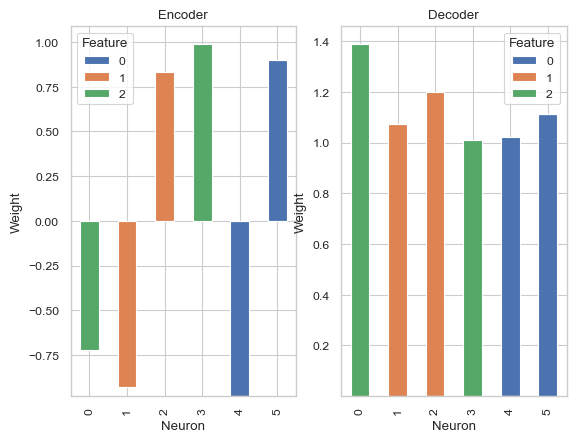

In [119]:
import seaborn as sns
import pandas as pd
sns.set_theme(style="whitegrid")
sns.set_context("paper")

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2)

# stacked bar plot for encoder
df_encoder = pd.DataFrame(model.encoder.detach().cpu().numpy().T)
df_encoder.index.name = 'Neuron'
df_encoder.columns.name = 'Feature'
# reorder the data such that the neurons 0,5,2,1,3,4
df_encoder.plot(kind='bar', stacked=True, ax=axs[0])
axs[0].set_ylabel('Weight')
axs[0].set_title('Encoder')

# stacked bar plot for decoder
df_decoder = pd.DataFrame(model.decoder.detach().cpu().numpy())
df_decoder.index.name = 'Neuron'
df_decoder.columns.name = 'Feature'
df_decoder.plot(kind='bar', stacked=True, ax=axs[1])
axs[1].set_ylabel('Weight')
axs[1].set_title('Decoder')



In [521]:
num_features = 100
model_dimensions = 40
batch_size = 1024
one_minus_sparsity = [1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001]
num_epochs = 10000
models = []
for oms in one_minus_sparsity:
    sparsity = 1 - oms
    # the higher the sparsity the higher the batch size
    # scale batch size from 1000 to 50000
    # as sparsity goes from 0 to 1
    # batch_size = int(1000 + (1 - sparsity) * 49000)
    model = train_model_abs(num_features, model_dimensions, batch_size, sparsity, num_epochs, weight_decay=0.01, patience=7000, lr=.01)
    models.append(model)


 71%|███████   | 7093/10000 [00:53<00:19, 151.87it/s, loss=0.019, lr=0.001]  

Epoch 07065: reducing learning rate of group 0 to 1.0000e-03.


100%|██████████| 10000/10000 [01:10<00:00, 141.13it/s, loss=0.00215, lr=0.01]


In [522]:
generate_data_abs(num_features, 1, sparsity)

tensor([[0., -0., 0., -0., 0., 0., -0., -0., 0., -0., -0., -0., -0., 0., -0., -0., 0., 0., 0., -0., -0., 0., -0., -0.,
         -0., 0., -0., -0., -0., 0., 0., -0., -0., -0., 0., 0., -0., -0., -0., 0., 0., 0., -0., -0., -0., -0., -0., -0.,
         -0., -0., 0., 0., 0., -0., -0., -0., -0., 0., 0., -0., 0., -0., 0., 0., 0., 0., 0., 0., -0., 0., -0., -0.,
         0., -0., -0., -0., 0., -0., -0., -0., -0., 0., -0., -0., -0., -0., -0., -0., 0., -0., -0., 0., -0., 0., 0., 0.,
         -0., -0., -0., 0.]])

(100,)


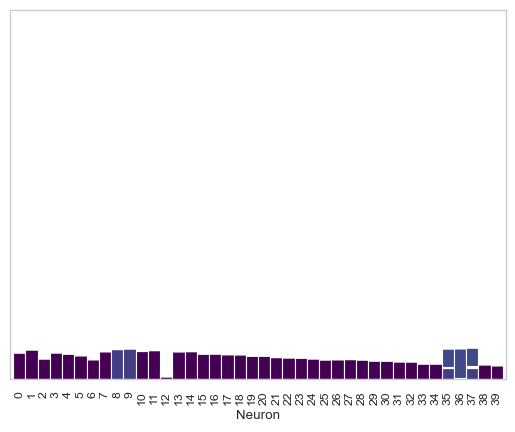

(100,)


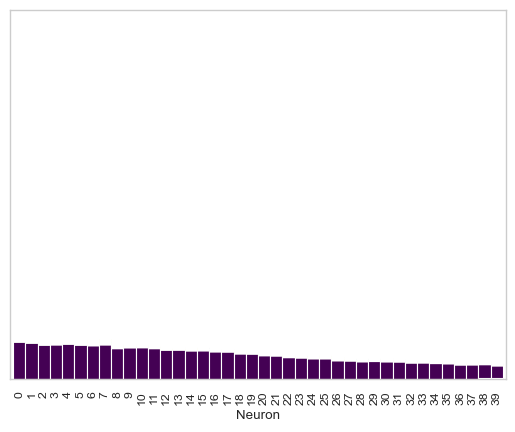

(100,)


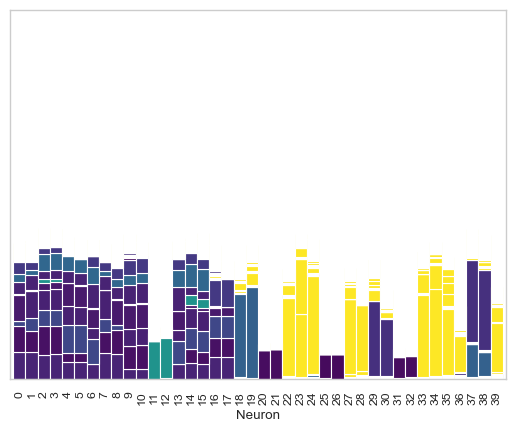

(100,)


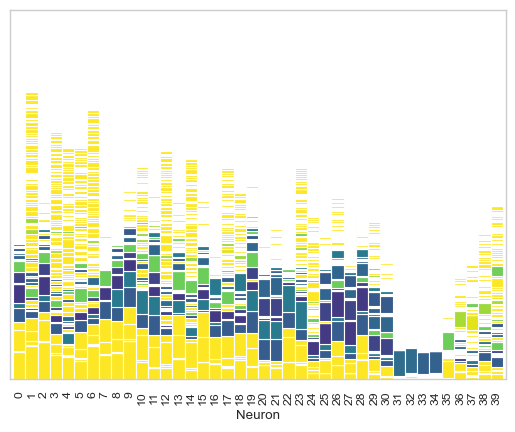

(100,)


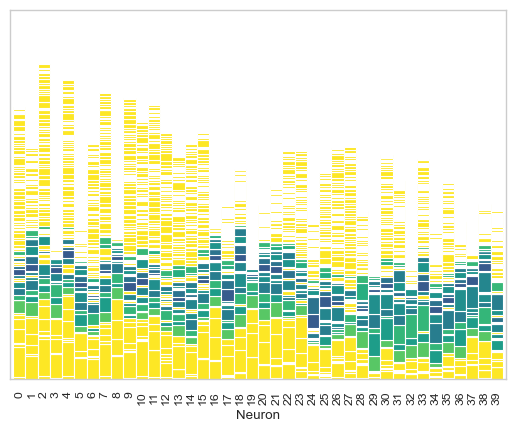

(100,)


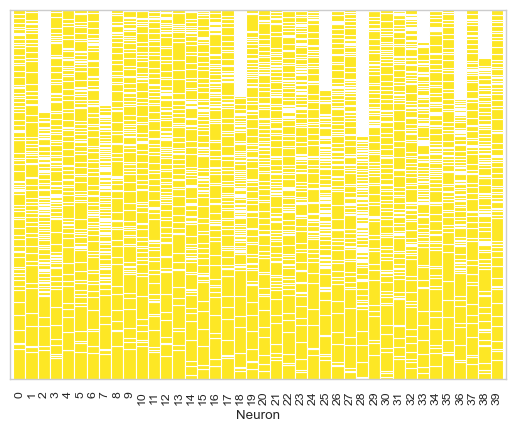

(100,)


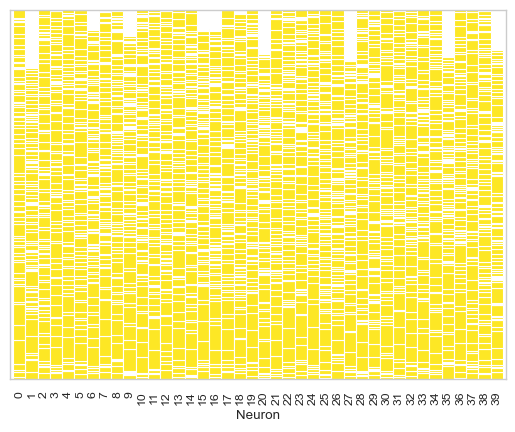

In [523]:
def plot_model_data(model):
    import seaborn as sns
    import pandas as pd
    import copy
    import numpy as np
    sns.set_theme(style="whitegrid")
    sns.set_context("paper")
    e = copy.deepcopy(model.encoder.detach().cpu().numpy()).T

    W = e
    W_norm = W / (1e-5 + np.linalg.norm(W, axis=0, keepdims=True))  # Normalized weights

    interference = np.dot(W_norm.T, W)  # Interference calculation (dot product of all pairs of normalized weight vectors)
    np.fill_diagonal(interference, 0)  # Remove self-interference by setting diagonal to 0

    overlaps = np.sum(interference**2 - np.diag(np.diag(interference**2)), axis=1)  # Overlaps (sum of squared cosine similarities, excluding self-comparison)

    # Polysemanticity (L2 norm of interference for each feature)
    polysemanticity = np.linalg.norm(interference, axis=1)

    # Overlaps (sum of squared cosine similarities, excluding self-comparison)
    overlaps = np.sum(interference**2 - np.diag(np.diag(interference**2)), axis=1)
    print(overlaps.shape)

    # Norms (L2 norm of the original weight vectors)
    norms = np.linalg.norm(W, axis=0)

    e = np.abs(e)
    # for every neuron, which feature has largest value?
    biggest_feature = np.argmax(np.abs(e), axis=1)
    # order the neurons based on the biggest feature
    e = e[np.argsort(biggest_feature)]
    # only keep values > 2 std
    #e[e < e.mean() + e.std()] = 0
    df = pd.DataFrame(e)
    df.index.name = 'Neuron'
    df.columns.name = 'Feature'

    # Create a colormap based on overlaps
    cmap = plt.cm.viridis

    # Normalize the overlaps to get values between 0 and 1 for the colormap
    normed_overlaps = overlaps

    # Create a colormap
    cmap = plt.cm.viridis

    # Normalize the overlaps vector between 0 and 1
    normed_overlaps = np.clip(normed_overlaps, 0, 1)

    # Generate colors for each bar based on normalized overlaps
    bar_colors = [cmap(normed_overlaps[i]) for i in range(len(normed_overlaps))]

    # Plot the bar chart
    ax = df.plot(kind='bar', stacked=True, legend=False, width=1, color=bar_colors)
    plt.ylim([0, 18])
    # no grid
    ax.grid(False)
    # no y axis ticks and labels
    ax.set_yticks([])

    # Show the plot
    plt.show()

for model in models:
    plot_model_data(model)


In [373]:
e = copy.deepcopy(model.encoder.detach().cpu().numpy().T)
e = np.abs(e)
e

array([[0.04869615, 0.01957241, 0.28529546, ..., 0.06186027, 0.00244351,
        0.02009179],
       [0.00795876, 0.00666022, 0.13799563, ..., 0.01776595, 0.0018421 ,
        0.02627568],
       [0.0026814 , 0.00049496, 0.27261347, ..., 0.02555408, 0.03725122,
        0.12254362],
       ...,
       [0.02303726, 0.03007173, 0.24919805, ..., 0.01339765, 0.01132934,
        0.0037627 ],
       [0.00199156, 0.00285256, 0.01322388, ..., 0.00132067, 0.01177763,
        0.00338448],
       [0.02529826, 0.02068442, 0.41978672, ..., 0.01874986, 0.01273817,
        0.09423093]], dtype=float32)

In [120]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class Autoencoder_compute(nn.Module):
    def __init__(self, input_dim, hidden_dim, sparsity_levels):
        super(Autoencoder_compute, self).__init__()
        # Adjusted to include sparsity_levels as an extra dimension
        self.encoder = nn.Parameter(torch.Tensor(sparsity_levels, input_dim, hidden_dim))
        self.decoder = nn.Parameter(torch.Tensor(sparsity_levels, hidden_dim, input_dim))
        nn.init.xavier_uniform_(self.encoder)
        nn.init.xavier_uniform_(self.decoder)
        self.relu = nn.ReLU()
        # Adjusted bias to include sparsity_levels as an extra dimension
        self.bias = nn.Parameter(torch.zeros(sparsity_levels, 1, input_dim))

    def forward(self, x):
        # x shape should now be (sparsity_levels, batch_size, input_dim)
        h = self.relu(torch.matmul(x, self.encoder))  # shape (sparsity_levels, batch_size, hidden_dim)
        matmul_result = torch.matmul(h, self.decoder)  # shape (sparsity_levels, batch_size, input_dim)
        # Add bias, broadcasting across the sparsity and batch dimensions
        result_with_bias = matmul_result + self.bias
        y_hat = self.relu(result_with_bias)  # shape (sparsity_levels, batch_size, input_dim)
        return y_hat
        
def loss_fn(y_pred, y_true, importance):
    mse = (y_pred - y_true)**2  # shape (batch_size, n_features)
    weighted_mse = mse * importance.unsqueeze(0)  # Apply importance weights
    loss = torch.mean(weighted_mse, dim=1)  # Average over the features
    return loss.sum()  # Sum the losses across the batch

def train_model_abs(num_features, model_dimensions, batch_size, sparsity_levels, num_epochs, lr=1e-2, weight_decay=0.0, patience=500):
    model = Autoencoder_compute(num_features, model_dimensions, len(sparsity_levels))
    model = model.to(device)
    importance = torch.tensor([0.8**i for i in range(num_features)], dtype=torch.float).to(device)

    # Define the optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Define the scheduler for learning rate decay
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, verbose=True,
                                                        min_lr=lr/10)

    # Training loop, use tqdm notebook
    pbar = tqdm(total=num_epochs, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]')

    for epoch in range(num_epochs):
        x = torch.stack([generate_data_abs(num_features, batch_size, s) for s in sparsity_levels], dim=0)
        x = x.to(device)
        output = model(x)

        # Compute loss for each sparsity level and sum them up
        loss = torch.sum(torch.stack([loss_fn(output[s], torch.abs(x[s]), importance) for s in range(len(sparsity_levels))]))


        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        scheduler.step(loss)
        pbar.set_postfix({'loss': loss.item(), 'lr': optimizer.param_groups[0]['lr']})
        pbar.update()

    return model

def generate_data_abs(n_features, n_samples, sparsity):
    x = 2 * torch.rand(n_samples, n_features) - 1
    mask = torch.rand_like(x) > sparsity
    x = torch.mul(x, mask.float())
    return x # shape (batch_size, n_features)

In [124]:
num_features = 100
model_dimensions = 40
batch_size = 1024*4
one_minus_sparsity = [1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001]
sparsity_levels = [1 - oms for oms in one_minus_sparsity]
num_epochs = 10000
lr = 0.01
weight_decay = 0.01
patience = 20000

# Train a single model that handles all sparsity levels simultaneously
model = train_model_abs(num_features, model_dimensions, batch_size, sparsity_levels, num_epochs, lr=lr, weight_decay=weight_decay, patience=patience)

# Instead of maintaining a list of models, you only have one model with parameters that incorporate all sparsity levels
models = model


  0%|          | 0/10000 [00:00<?, ?it/s]

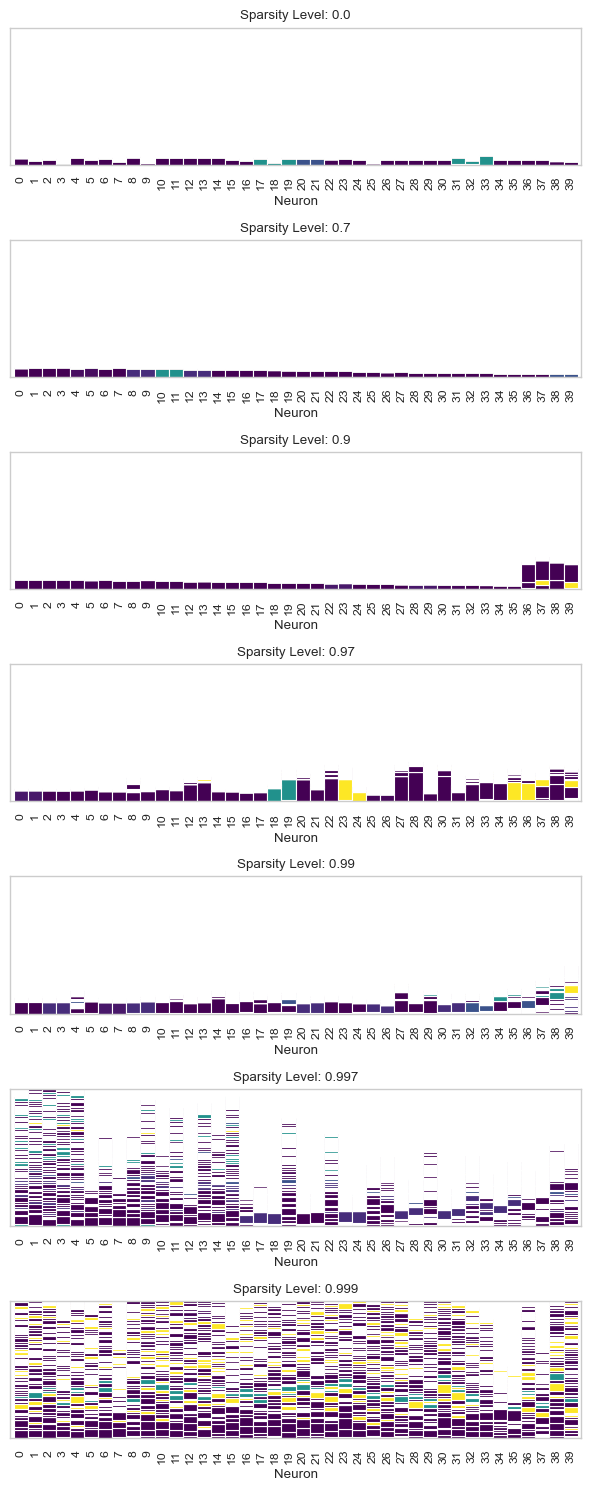

In [125]:
import seaborn as sns
import pandas as pd
import copy
import matplotlib.pyplot as plt

def plot_model_data(encoder_weights, sparsity_level, ax):
    sns.set_theme(style="whitegrid")
    sns.set_context("paper")

    # Normalize weights and calculate interference as before
    W_norm = encoder_weights / (1e-5 + np.linalg.norm(encoder_weights, axis=0, keepdims=True))
    interference = np.dot(W_norm.T, W_norm)
    np.fill_diagonal(interference, 0)

    # Compute polysemanticity and overlaps
    polysemanticity = np.linalg.norm(interference, axis=1)
    overlaps = np.sum(interference**2, axis=1) - polysemanticity**2

    # Create DataFrame for seaborn
    e_abs = np.abs(encoder_weights)
    biggest_feature = np.argmax(e_abs, axis=1)
    sorted_neurons = np.argsort(biggest_feature)
    e_sorted = e_abs[sorted_neurons]
    
    df = pd.DataFrame(e_sorted)
    df.index.name = 'Neuron'
    df.columns.name = 'Feature'

    # Create colormap based on overlaps
    cmap = plt.cm.viridis
    normed_overlaps = np.clip(overlaps / np.max(overlaps), 0, 1)
    bar_colors = [cmap(no) for no in normed_overlaps]

    # Plot the stacked bar chart
    df.plot(kind='bar', stacked=True, legend=False, width=1, color=bar_colors, ax=ax)
    ax.set_title(f'Sparsity Level: {sparsity_level}')
    ax.grid(False)
    ax.set_yticks([])
    ax.set_ylim([0, 20])  # Set y limit to 20

# Create a figure with 7 subplots, 1 column 7 rows
fig, axs = plt.subplots(7, 1, figsize=(6, 15))  # Adjust the figure size to make each plot shorter

# Assuming you have a list of models for different sparsity levels
for idx, s in enumerate(sparsity_levels):
    encoder_weights = model.encoder[idx].detach().cpu().numpy()  # Extract weights for the current sparsity level
    plot_model_data(encoder_weights.T, s, axs[idx])

plt.tight_layout()
plt.show()

In [21]:
encoder_weights

array([ 1.60905637e-03,  4.35680733e-04,  2.42657712e-04,  9.62520480e-01,
        1.42933812e-03,  8.41520429e-01,  2.21976335e-03,  1.43205759e-03,
       -8.50331962e-01, -2.69300672e-05, -1.64087818e-04,  6.30233379e-04,
        1.78849717e-04,  9.13153868e-04, -1.52099272e-03,  1.32216699e-03,
        6.91345394e-01, -8.36007239e-04, -5.17876470e-04,  8.02556694e-01,
       -1.87477111e-04,  8.67240480e-04,  2.57832231e-03,  4.89714183e-03,
       -2.96935847e-04,  2.35331850e-03, -1.53185939e-03,  1.22431340e-03,
        3.30067152e-04, -9.89093794e-04,  6.96818403e-04,  1.19219837e-03,
       -7.08615959e-01, -7.43575573e-01, -8.04756826e-04,  6.73114148e-04,
        3.97991185e-04, -9.05386448e-01,  1.14849945e-05,  2.27800733e-03],
      dtype=float32)

In [596]:
class Autoencoder_compute(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder_compute, self).__init__()
        self.encoder = nn.Parameter(torch.Tensor(input_dim, hidden_dim))
        self.decoder = nn.Parameter(torch.Tensor(hidden_dim, input_dim))
        nn.init.xavier_uniform_(self.encoder)
        nn.init.xavier_uniform_(self.decoder)
        self.relu = nn.ReLU()
        # Initialize bias to be of size (1, input_dim)
        self.bias = nn.Parameter(torch.zeros(1, input_dim))

    def forward(self, x):
        h = self.relu(torch.matmul(x, self.encoder))  # x @ encoder
        matmul_result = torch.matmul(h, self.decoder)  
        # Add bias, broadcasting across the batch dimension
        result_with_bias = matmul_result + self.bias
        y_hat = self.relu(result_with_bias)
        return y_hat

def train_model_abs(num_features, model_dimensions, batch_size, sparsity, num_epochs, lr=1e-2, weight_decay=0.0, patience=500):
    # Define the model
    model = Autoencoder_compute(num_features, model_dimensions)

    # use loss_fn as the loss function
    importance = [0.6**i for i in range(num_features)]
    #importance = (100 ** -torch.linspace(0, 1, num_features)).numpy()
    importance = [1.0 for i in range(num_features)]
    # make last two features 0.5
    #importance[-2:] = [1.0, 0.5]
    criterion = lambda y_pred, y_true: loss_fn(y_pred, y_true, importance)

    # Define the optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Define the scheduler for learning rate decay
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
    # reduce lr on plataue
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, verbose=True)

    # Training loop
    with tqdm(total=num_epochs, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]') as pbar:
        for epoch in range(num_epochs):
            
            x = generate_data_abs(num_features, batch_size, sparsity)
            # ===================forward=====================
            output = model(x)
            loss = criterion(output, torch.abs(x))
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # ===================log========================
            pbar.set_postfix({'loss': loss.item(), 'lr': optimizer.param_groups[0]['lr']})
            pbar.update()

            # Step the learning rate scheduler
            scheduler.step(loss)

    return model

def generate_data_abs(n_features, n_samples, sparsity):
    x = 2 * torch.rand(n_samples, n_features) - 1
    mask = torch.rand_like(x) > sparsity
    x = torch.mul(x, mask.float())
    return x # shape (batch_size, n_features)

def loss_fn(y_pred, y_true, importance):
    weights = torch.Tensor(importance).to(y_true.device)
    mse = (y_pred - y_true)**2 # shape (batch_size, n_features)
    # now for loss, we want the weights to be applied to each column
    loss = torch.einsum('bi,i->b', mse, weights) # shape (batch_size,)
    return torch.mean(loss)


In [610]:
num_features = 1
model_dimensions = 2
batch_size = 1024
sparsity = 0.
num_epochs = 3000
lr = 0.01
weight_decay = 0.01
patience = 20000

model = train_model_abs(num_features, model_dimensions, batch_size, sparsity, num_epochs, lr=lr, weight_decay=weight_decay, patience=patience)

  0%|          | 0/3000 [00:00<?, ?it/s]

KeyboardInterrupt: 

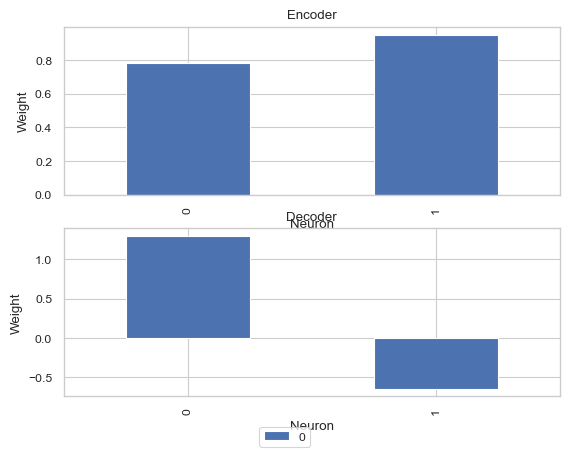

In [609]:
import seaborn as sns
import pandas as pd
sns.set_theme(style="whitegrid")
sns.set_context("paper")

# Define a subset of the neurons to plot
#neurons_to_plot = [1, 2, 4,  9]  # Change this to select different neurons
neurons_to_plot = np.arange(model_dimensions)
# Create a figure and a set of subplots
fig, axs = plt.subplots(2,1)

# stacked bar plot for encoder
df_encoder = pd.DataFrame(model.encoder.detach().cpu().numpy().T)
df_encoder = df_encoder.loc[neurons_to_plot]  # Select only the neurons to plot
df_encoder.index.name = 'Neuron'
df_encoder.columns.name = 'Feature'
# reorder the data such that the neurons 0,5,2,1,3,4
df_encoder.plot(kind='bar', stacked=True, ax=axs[0], legend=False)
axs[0].set_ylabel('Weight')
axs[0].set_title('Encoder')

# stacked bar plot for decoder
df_decoder = pd.DataFrame(model.decoder.detach().cpu().numpy())
df_decoder = df_decoder.loc[neurons_to_plot]  # Select only the neurons to plot
df_decoder.index.name = 'Neuron'
df_decoder.columns.name = 'Feature'
df_decoder.plot(kind='bar', stacked=True, ax=axs[1], legend=False)
axs[1].set_ylabel('Weight')
axs[1].set_title('Decoder')

# Add a single legend for the entire figure, all the way on the bottom underneath everything, horizontal
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels))



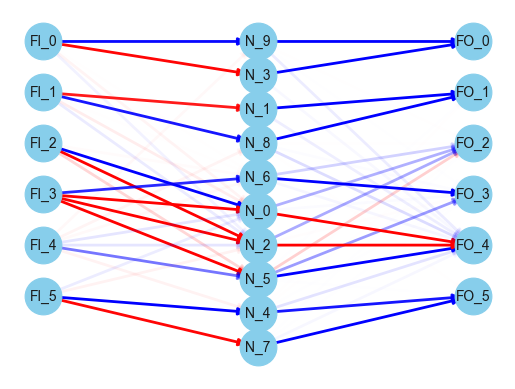

In [458]:
def plot_network(encoder_weights, decoder_weights, neuron_indices):
    # Initialize the graph
    G = nx.DiGraph()

    # Define nodes for input features, hidden neurons, and output features
    input_features = [f'FI_{i}' for i in range(encoder_weights.shape[0])]
    hidden_neurons = [f'N_{i}' for i in neuron_indices]
    output_features = [f'FO_{i}' for i in range(decoder_weights.shape[0])]

    # Add the nodes to the graph with their layer attribute
    G.add_nodes_from(input_features, layer='input')
    G.add_nodes_from(hidden_neurons, layer='hidden')
    G.add_nodes_from(output_features, layer='output')

    # Define positions for the input and output layer nodes
    pos = {}
    y_offset = max(len(input_features), len(output_features)) / 2
    pos.update((node, (0, -i + y_offset)) for i, node in enumerate(input_features))
    pos.update((node, (2, -i + y_offset)) for i, node in enumerate(output_features))

    # Position the hidden layer nodes in the middle
    hidden_layer_y_positions = np.linspace(-y_offset, y_offset, len(hidden_neurons))
    pos.update((node, (1, y_pos)) for node, y_pos in zip(hidden_neurons, hidden_layer_y_positions))

    # Add edges from input nodes to hidden nodes based on encoder weights
    for neuron_idx, hidden_node in zip(neuron_indices, hidden_neurons):
        for i, input_node in enumerate(input_features):
            weight = encoder_weights[i][neuron_idx]
            color = 'blue' if weight >= 0 else 'red'
            alpha = min(abs(weight), 1)
            G.add_edge(input_node, hidden_node, weight=weight, color=color, alpha=alpha)

    # Add edges from hidden nodes to output nodes based on decoder weights
    for neuron_idx, hidden_node in zip(neuron_indices, hidden_neurons):
        for i, output_node in enumerate(output_features):
            weight = decoder_weights[i][neuron_idx]
            color = 'blue' if weight >= 0 else 'red'
            alpha = min(abs(weight), 1)
            G.add_edge(hidden_node, output_node, weight=weight, color=color, alpha=alpha)

    # Draw the graph components
    nodes = nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)
    labels = nx.draw_networkx_labels(G, pos, font_size=10)

    # Draw edges with color and alpha
    for (u, v, attr) in G.edges(data=True):
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=2, edge_color=attr['color'], alpha=attr['alpha'])

    # Show plot
    plt.axis('off')
    plt.show()

# Assuming model.encoder and model.decoder are the weight matrices for the encoder and decoder
encoder_weights = model.encoder.detach().cpu().numpy()
decoder_weights = model.decoder.detach().cpu().numpy().T

# List of neuron indices to display in the middle layer
neuron_indices = np.flip([0,4,1,5,9,6])  # Example indices

neuron_indices = np.flip([7,8,2,3])  # Example indices
# Plot the network visualization for the specified neurons
neuron_indices = np.flip([9,3, 1,8,6,0,2,5,4,7])  # Example indices

# Plot the network visualization for the specified neurons
plot_network(encoder_weights, decoder_weights, neuron_indices)

In [335]:
decoder_weights

array([[-1.7189160e-03,  1.0910794e+00, -5.8976691e-03,  3.3872193e-03,
        -1.3565526e-03, -3.4212496e-03,  1.7166743e-03,  3.3861340e-03,
         1.0627004e+00,  1.3795014e-03],
       [-4.6415580e-03, -2.6211550e-03, -1.1260280e-02,  8.4696370e-01,
         2.8507918e-04,  8.5206354e-01, -3.6567243e-04,  6.4584552e-03,
         2.5443465e-03,  3.7157377e-03],
       [ 2.8995407e-04,  1.1380330e-02,  1.4217061e+00,  9.8447017e-05,
        -1.0649298e-03, -1.0113997e-04,  1.3558471e-03,  8.2158178e-01,
        -1.1172533e-02, -2.3482741e-04],
       [-1.5743430e-04, -8.5499221e-03, -5.7415699e-04,  1.8524661e-03,
         1.0151868e+00, -1.8722202e-03,  1.2860932e+00,  3.3092708e-04,
         8.2873730e-03,  1.2646474e-04],
       [ 9.0047491e-01,  1.5102505e-03, -1.7132990e-02, -3.4022453e-04,
        -4.3452160e-06,  3.4137213e-04,  9.5181858e-06,  9.7775329e-03,
        -1.4760459e-03,  7.2559083e-01],
       [-2.5526986e-03, -3.0547590e-03, -1.6775023e-04, -2.0064979e-03,
   

In [612]:
class Autoencoder_compute(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder_compute, self).__init__()
        self.encoder = nn.Parameter(torch.Tensor(input_dim, hidden_dim))
        self.decoder = nn.Parameter(torch.Tensor(hidden_dim, input_dim))
        nn.init.xavier_uniform_(self.encoder)
        nn.init.xavier_uniform_(self.decoder)
        self.relu = nn.ReLU()
        # Initialize bias to be of size (1, input_dim)
        self.bias = nn.Parameter(torch.zeros(1, input_dim))

    def forward(self, x):
        h = self.relu(torch.matmul(x, self.encoder))  # x @ encoder
        matmul_result = torch.matmul(h, self.decoder)  
        # Add bias, broadcasting across the batch dimension
        result_with_bias = matmul_result + self.bias
        y_hat = self.relu(result_with_bias)
        return y_hat

def train_model_squared(num_features, model_dimensions, batch_size, sparsity, num_epochs, lr=1e-2, weight_decay=0.0, patience=500):
    # Define the model
    model = Autoencoder_compute(num_features, model_dimensions)

    # use loss_fn as the loss function
    importance = [0.4**i for i in range(num_features)]
    #importance = (100 ** -torch.linspace(0, 1, num_features)).numpy()
    #importance = [1.0 for i in range(num_features)]
    # make last two features 0.5
    #importance[-2:] = [1.0, 0.5]
    criterion = lambda y_pred, y_true: loss_fn(y_pred, y_true, importance)

    # Define the optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Define the scheduler for learning rate decay
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
    # reduce lr on plataue
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, verbose=True)

    # Training loop
    with tqdm(total=num_epochs, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]') as pbar:
        for epoch in range(num_epochs):
            
            x = generate_data_abs(num_features, batch_size, sparsity)
            # ===================forward=====================
            output = model(x)
            # output should be elementwise squared
            loss = criterion(output, x**2)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # ===================log========================
            pbar.set_postfix({'loss': loss.item(), 'lr': optimizer.param_groups[0]['lr']})
            pbar.update()

            # Step the learning rate scheduler
            scheduler.step(loss)

    return model

def generate_data_abs(n_features, n_samples, sparsity):
    # make x go from -1 to 1
    x = 4 * torch.rand(n_samples, n_features) - 2
    mask = torch.rand_like(x) > sparsity
    x = torch.mul(x, mask.float())
    return x # shape (batch_size, n_features)

def loss_fn(y_pred, y_true, importance):
    weights = torch.Tensor(importance).to(y_true.device)
    mse = (y_pred - y_true)**2 # shape (batch_size, n_features)
    # now for loss, we want the weights to be applied to each column
    loss = torch.einsum('bi,i->b', mse, weights) # shape (batch_size,)
    return torch.mean(loss)


In [613]:
generate_data_abs(5, 1, 0.)

tensor([[-0.7610,  0.0133, -1.6728, -0.6153,  0.2556]])

In [627]:
num_features =  10
model_dimensions = [5,10,20,40]
batch_size = 1024
sparsity = 0.15
num_epochs = 8000
lr = 1e-2
weight_decay = 0.01
patience = 2000

models = []
for md in model_dimensions:
    models.append(train_model_squared(num_features, md, batch_size, sparsity, num_epochs, lr=lr, weight_decay=weight_decay, patience=patience))


  0%|          | 0/8000 [00:00<?, ?it/s]

Epoch 04235: reducing learning rate of group 0 to 1.0000e-03.
Epoch 06236: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/8000 [00:00<?, ?it/s]

Epoch 04547: reducing learning rate of group 0 to 1.0000e-03.


  0%|          | 0/8000 [00:00<?, ?it/s]

Epoch 04709: reducing learning rate of group 0 to 1.0000e-03.
Epoch 06710: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/8000 [00:00<?, ?it/s]

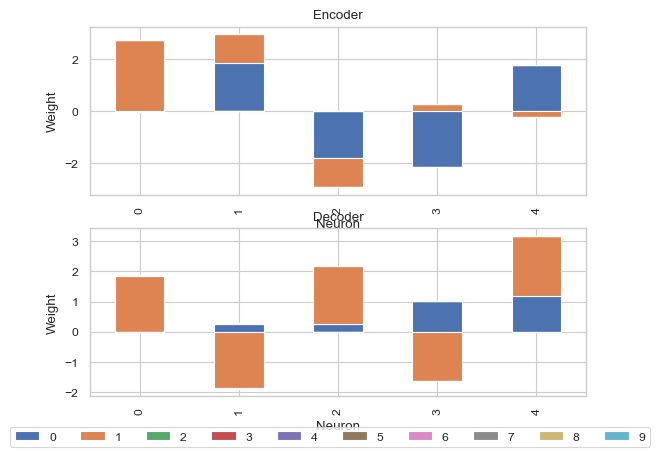

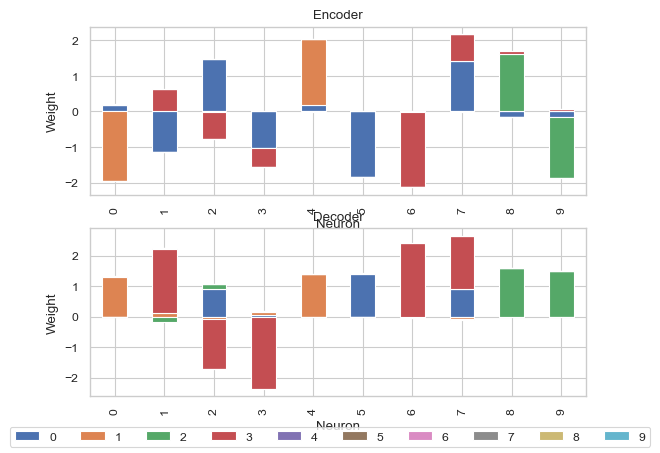

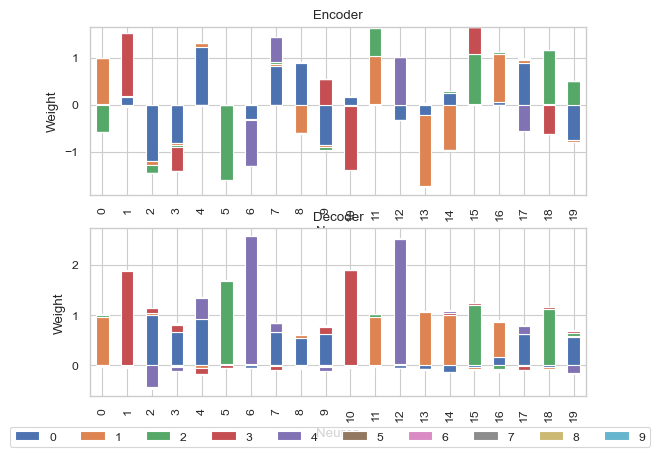

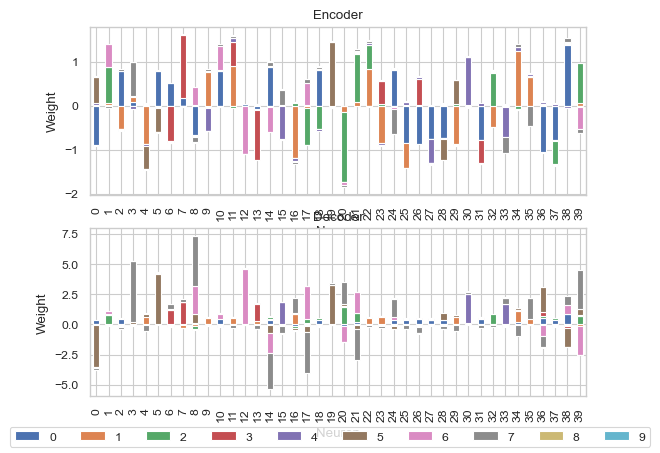

In [628]:
def plot_model_weights(model):
    import seaborn as sns
    import pandas as pd
    sns.set_theme(style="whitegrid")
    sns.set_context("paper")

    # Define a subset of the neurons to plot
    model_dimensions = model.decoder.shape[0]
    neurons_to_plot = np.arange(model_dimensions)

    # Create a figure and a set of subplots
    fig, axs = plt.subplots(2,1)

    # stacked bar plot for encoder
    df_encoder = pd.DataFrame(model.encoder.detach().cpu().numpy().T)
    df_encoder = df_encoder.loc[neurons_to_plot]  # Select only the neurons to plot
    df_encoder.index.name = 'Neuron'
    df_encoder.columns.name = 'Feature'
    df_encoder.plot(kind='bar', stacked=True, ax=axs[0], legend=False)
    axs[0].set_ylabel('Weight')
    axs[0].set_title('Encoder')

    # stacked bar plot for decoder
    df_decoder = pd.DataFrame(model.decoder.detach().cpu().numpy())
    df_decoder = df_decoder.loc[neurons_to_plot]  # Select only the neurons to plot
    df_decoder.index.name = 'Neuron'
    df_decoder.columns.name = 'Feature'
    df_decoder.plot(kind='bar', stacked=True, ax=axs[1], legend=False)
    axs[1].set_ylabel('Weight')
    axs[1].set_title('Decoder')

    # Add a single legend for the entire figure, all the way on the bottom underneath everything, horizontal
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(labels))

    return fig, axs

for model in models:
    fig, axs = plot_model_weights(model)
    plt.show()


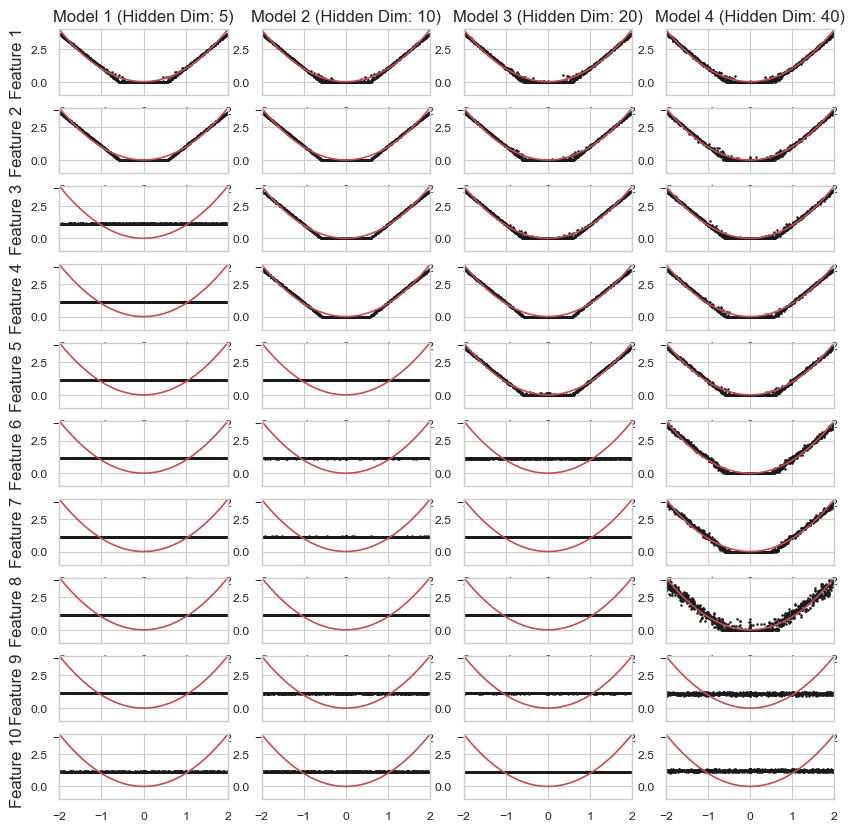

In [652]:
from matplotlib import cm
from matplotlib import colors
# make a batch of data
x = generate_data_abs(num_features, 1000, sparsity)

# run the data through each model
outputs = []
for model in models:
    outputs.append(model(x).detach().cpu().numpy())

n_models = len(models)
fig, axs = plt.subplots( num_features, n_models, figsize=(10, 10))  # Adjust the figure size to make each plot shorter
for model in range(len(models)):
    c = cm.viridis(colors.Normalize(vmin=0, vmax=1)(np.arange(num_features)))
    for feature in range(num_features):
        plt.sca(axs[feature, model])
        plt.scatter(x[:,feature], outputs[model][:,feature], label=f'model {model}', color='k', s=1)
        xx = np.linspace(-2,2,100)
        plt.plot(xx, xx**2, color='r')
        plt.xlim([-2,2])
        plt.ylim([-1,4])
        if model == 0:
            plt.ylabel(f'Feature {feature+1}', fontsize=12)
        if feature == 0:
            plt.title(f'Model {model+1} (Hidden Dim: {models[model].encoder.shape[1]})', fontsize=12)


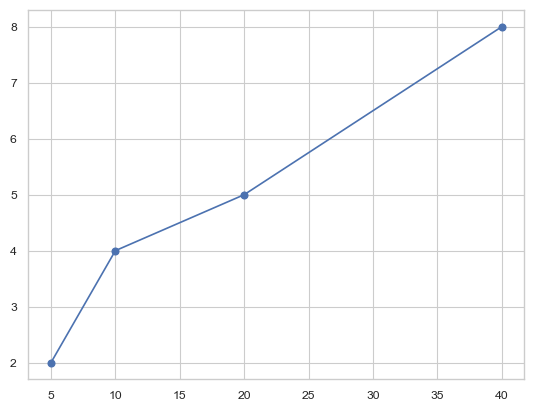

In [654]:
model_dims = [5,10,20,40]
num_x_squared = [2,4,5,8]
plt.plot(model_dims, num_x_squared, 'o-')

(10, 5)
(10, 5)
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
0 3
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4


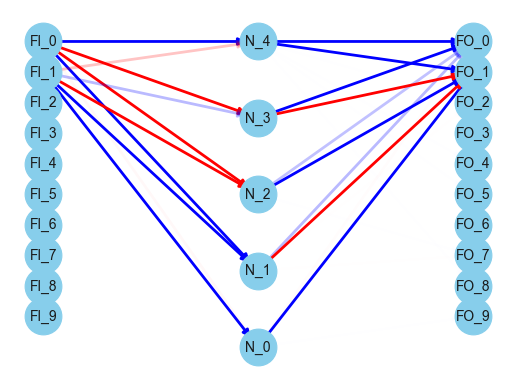

In [655]:
def plot_network(encoder_weights, decoder_weights, neuron_indices):
    # Initialize the graph
    G = nx.DiGraph()

    # Define nodes for input features, hidden neurons, and output features
    input_features = [f'FI_{i}' for i in range(encoder_weights.shape[0])]
    hidden_neurons = [f'N_{i}' for i in neuron_indices]
    output_features = [f'FO_{i}' for i in range(decoder_weights.shape[0])]

    # Add the nodes to the graph with their layer attribute
    G.add_nodes_from(input_features, layer='input')
    G.add_nodes_from(hidden_neurons, layer='hidden')
    G.add_nodes_from(output_features, layer='output')

    # Define positions for the input and output layer nodes
    pos = {}
    y_offset = max(len(input_features), len(output_features)) / 2
    pos.update((node, (0, -i + y_offset)) for i, node in enumerate(input_features))
    pos.update((node, (2, -i + y_offset)) for i, node in enumerate(output_features))

    # Position the hidden layer nodes in the middle
    hidden_layer_y_positions = np.linspace(-y_offset, y_offset, len(hidden_neurons))
    pos.update((node, (1, y_pos)) for node, y_pos in zip(hidden_neurons, hidden_layer_y_positions))

    # Add edges from input nodes to hidden nodes based on encoder weights
    for neuron_idx, hidden_node in zip(neuron_indices, hidden_neurons):
        for i, input_node in enumerate(input_features):
            print(i, neuron_idx)
            weight = encoder_weights[i][neuron_idx]
            color = 'blue' if weight >= 0 else 'red'
            alpha = min(abs(weight), 1)
            G.add_edge(input_node, hidden_node, weight=weight, color=color, alpha=alpha)

    # Add edges from hidden nodes to output nodes based on decoder weights
    for neuron_idx, hidden_node in zip(neuron_indices, hidden_neurons):
        for i, output_node in enumerate(output_features):
            weight = decoder_weights[i][neuron_idx]
            color = 'blue' if weight >= 0 else 'red'
            alpha = min(abs(weight), 1)
            G.add_edge(hidden_node, output_node, weight=weight, color=color, alpha=alpha)

    # Draw the graph components
    nodes = nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)
    labels = nx.draw_networkx_labels(G, pos, font_size=10)

    # Draw edges with color and alpha
    for (u, v, attr) in G.edges(data=True):
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=2, edge_color=attr['color'], alpha=attr['alpha'])

    # Show plot
    plt.axis('off')
    plt.show()

model = models[0]
# Assuming model.encoder and model.decoder are the weight matrices for the encoder and decoder
encoder_weights = model.encoder.detach().cpu().numpy()
decoder_weights = model.decoder.detach().cpu().numpy().T
print(encoder_weights.shape)
print(decoder_weights.shape)

# List of neuron indices to display in the middle layer
neuron_indices = np.flip([0,4,1,5,9,6])  # Example indices

neuron_indices = np.flip([7,8,2,3])  # Example indices
# Plot the network visualization for the specified neurons
neuron_indices = np.flip([9,3, 1,8,6,0,2,5,4,7])  # Example indices
neuron_indices = np.arange(5)

# Plot the network visualization for the specified neurons
plot_network(encoder_weights, decoder_weights, neuron_indices)

In [656]:
# print model biases
model.bias

Parameter containing:
tensor([[-1.5269, -1.4948,  1.1331,  1.1307,  1.1315,  1.1341,  1.1320,  1.1316,
          1.1302,  1.1328]], requires_grad=True)

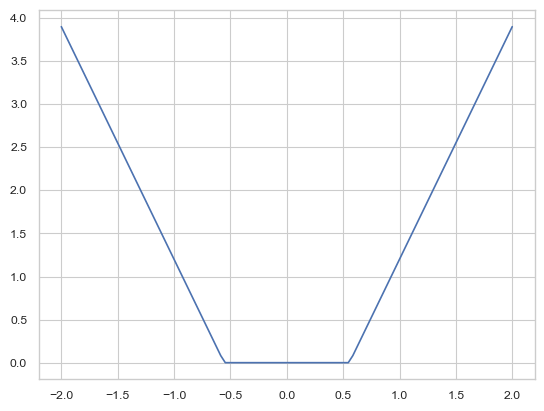

In [659]:
# plot relu 2.7x-1.5, x from -2 to 2
x = np.linspace(-2,2,100)
y = np.maximum(np.abs(2.7*x)-1.5, 0)
plt.plot(x,y)